In [41]:
import sys
sys.path.append("../script")
import random_forest as rf 

sys.path.append("../base_lib")
import models
import functions as func

import pandas as pd

In [42]:
dataset = rf.load_csv()
df = rf.oversampling_SMOTENC(dataset)
df = func.drop_cols(df)
dataset = func.drop_cols(dataset)

In [43]:
def train_test(dataset):
    y_test_0 = dataset[dataset['LUX_01']==0].sample(n=200)
    y_test_1 = dataset[dataset['LUX_01']==1].sample(n=100)
    lista_dataframe = [y_test_0, y_test_1]

    testing_set = pd.concat(lista_dataframe, ignore_index=True)

    # Esegui il merge tra i due dataset
    merged_df = df.merge(testing_set, on=df.columns.tolist(), how='inner', indicator=True)

    # Filtra le righe presenti in entrambi i DataFrame
    righe_comuni = merged_df[merged_df['_merge'] == 'both'].drop(columns='_merge')

    # Elimino da df le righe comuni presenti in testin_set
    merged_df = df.merge(righe_comuni, on=df.columns.tolist(), how='left', indicator=True)
    training_set = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

    return training_set, testing_set

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

feature_cols = ['BREED', 'GENDER_01', 'AGEATSURGERYmo', 'BODYWEIGHTKG', 'Taglia', 'BCS', 
                'YEAR', 'GENERATION', 'STEMSIZE', 'CUPSIZE', 'NECKSIZE', 'HEADSIZE', 'ALO', 'CUPRETROVERSION', 'STEMANTEVERSIONREAL', 
                'RECTUSFEMORISM.RELEASE', 'LUX_CR']

# Liste per tutte le metriche test
accuracies_test = []
precisions_test = []
recalls_test = []
f1_scores_test = []
roc_aucs_test = []

for i in range(10):

    training_set, testing_set = train_test(dataset)

    X_train = training_set[feature_cols]
    y_train = training_set['LUX_01']

    X_test = testing_set[feature_cols]
    y_test = testing_set['LUX_01']

    param_grid = {
        'n_estimators': [3, 4, 5],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
    }

    # Crea il modello di Random Forest
    clf = RandomForestClassifier(random_state=42)

    # Crea il Grid Search con lo scoring fissato a F1-score
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1_macro', cv=5)

    # Esegui il Grid Search per trovare i migliori parametri
    grid_search.fit(X_train, y_train)

    print("Risultati iterazione numero", i+1)

    # Estrai i migliori parametri e il miglior modello
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f'Best parameters found: {best_params}')

    # Fai delle predizioni sul set di test usando il miglior modello trovato
    predictions_test = best_model.predict(X_test)
    predictions_train = best_model.predict(X_train)

    # Valuta il modello sul testing set
    accuracy = accuracy_score(y_test, predictions_test)
    precision = precision_score(y_test, predictions_test, average='macro')
    recall = recall_score(y_test, predictions_test, average='macro')
    f1 = f1_score(y_test, predictions_test, average='macro')
    roc_auc = roc_auc_score(y_test, predictions_test, average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {roc_auc}')

    accuracies_test.append(accuracy)
    recalls_test.append(recall)
    precisions_test.append(precision)
    f1_scores_test.append(f1)
    roc_aucs_test.append(roc_auc)

    print("--------------------------------------------------------")

Risultati iterazione numero 1
Best parameters found: {'max_depth': 9, 'n_estimators': 3}
Accuracy: 0.6966666666666667
Precision: 0.660090403992843
Recall: 0.585
F1 Score: 0.5781764242339962
ROC-AUC: 0.5850000000000001
--------------------------------------------------------
Risultati iterazione numero 2
Best parameters found: {'max_depth': 10, 'n_estimators': 4}
Accuracy: 0.7
Precision: 0.6769128704113224
Recall: 0.58
F1 Score: 0.5676125808724617
ROC-AUC: 0.58
--------------------------------------------------------
Risultati iterazione numero 3
Best parameters found: {'max_depth': 10, 'n_estimators': 4}
Accuracy: 0.6933333333333334
Precision: 0.6603272888102609
Recall: 0.5725
F1 Score: 0.5580039715585164
ROC-AUC: 0.5725
--------------------------------------------------------
Risultati iterazione numero 4
Best parameters found: {'max_depth': 9, 'n_estimators': 4}
Accuracy: 0.73
Precision: 0.726223871142883
Recall: 0.625
F1 Score: 0.6281617725819038
ROC-AUC: 0.625
---------------------

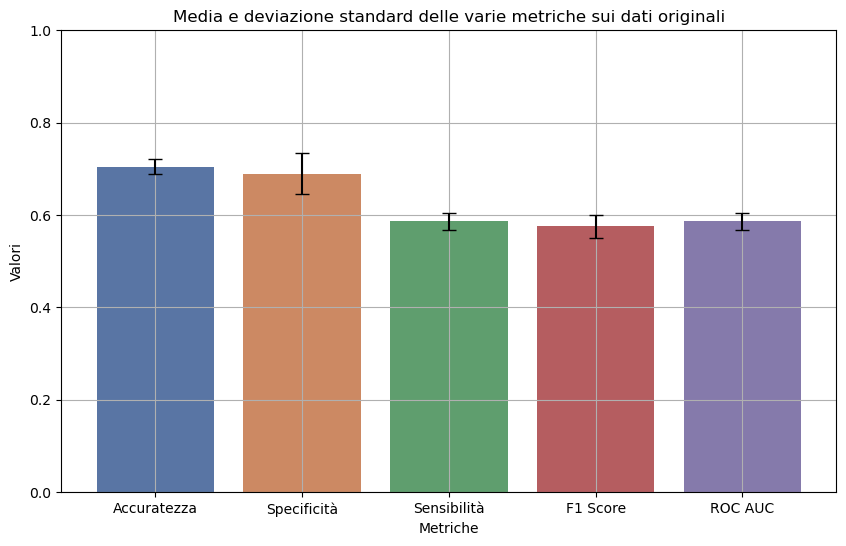

,Metrica,Media,Deviazione standard
0,Accuratezza,0.704333,0.015874
1,Specificità,0.688944,0.044320
2,Sensibilità,0.586000,0.019228
3,F1 Score,0.575259,0.025820
4,ROC AUC,0.586000,0.019228


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_test = {
    'Accuratezza': accuracies_test,
    'Specificità': precisions_test,
    'Sensibilità': recalls_test,
    'F1 Score': f1_scores_test,
    'ROC AUC': roc_aucs_test
}
metrics_summary_test = {
    'Metrica': [],
    'Media': [],
    'Deviazione standard': []
}

for metric_name, values in metrics_test.items():
    metrics_summary_test['Metrica'].append(metric_name)
    metrics_summary_test['Media'].append(sum(values) / len(values))
    metrics_summary_test['Deviazione standard'].append(pd.Series(values).std())

# Converto in un dataframe
metrics_df = pd.DataFrame(metrics_summary_test)

# Traccia il grafico con seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Metrica', y='Media', data=metrics_df, capsize=0.2, palette='deep', errorbar=None)

# Aggiungi gli error bars manualmente
for index, row in metrics_df.iterrows():
    plt.errorbar(x=index, y=row['Media'], yerr=row['Deviazione standard'], fmt='none', c='black', capsize=5)

plt.xlabel('Metriche')
plt.ylabel('Valori')
plt.title('Media e deviazione standard delle varie metriche sui dati originali')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

metrics_df

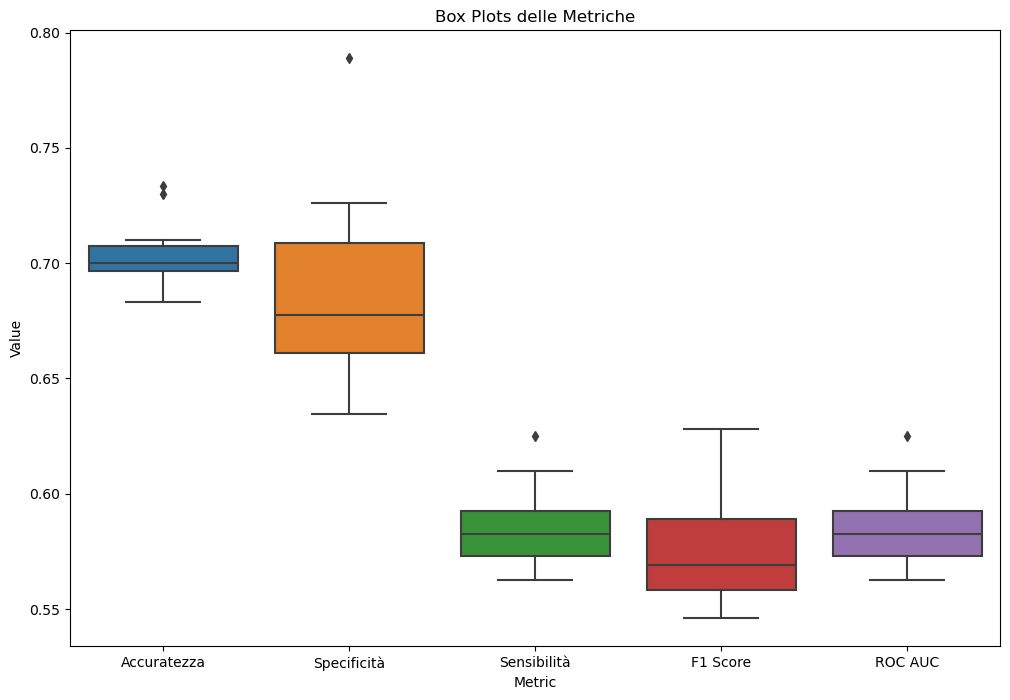

,Iterazione,Accuratezza,Specificità,Sensibilità,F1 Score,ROC AUC
0,1,0.696667,0.660090,0.5850,0.578176,0.5850
1,2,0.700000,0.676913,0.5800,0.567613,0.5800
2,3,0.693333,0.660327,0.5725,0.558004,0.5725
3,4,0.730000,0.726224,0.6250,0.628162,0.6250
4,5,0.700000,0.662616,0.5950,0.592662,0.5950
5,6,0.733333,0.788866,0.6100,0.602754,0.6100
6,7,0.700000,0.685185,0.5750,0.558101,0.5750
7,8,0.710000,0.716313,0.5850,0.570434,0.5850
8,9,0.683333,0.634771,0.5625,0.545998,0.5625
9,10,0.696667,0.678140,0.5700,0.550684,0.5700


In [46]:
# Create a DataFrame for the box plots
metrics_total_df = pd.DataFrame({
    'Iterazione': range(1, 11),
    'Accuratezza': accuracies_test,
    'Specificità': precisions_test,
    'Sensibilità': recalls_test,
    'F1 Score': f1_scores_test,
    'ROC AUC': roc_aucs_test
})

# Melt the DataFrame for easier plotting with seaborn
metrics_boxplot_melted = metrics_total_df.melt(id_vars=['Iterazione'], var_name='Metric', value_name='Value')

# Plot the box plots for each metric
plt.figure(figsize=(12, 8))
sns.boxplot(x='Metric', y='Value', data=metrics_boxplot_melted)
plt.title('Box Plots delle Metriche')
plt.ylabel('Value')
plt.show()

metrics_total_df

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

feature_cols = ['BREED', 'GENDER_01', 'AGEATSURGERYmo', 'BODYWEIGHTKG', 'Taglia', 'BCS', 
                'YEAR', 'GENERATION', 'STEMSIZE', 'CUPSIZE', 'NECKSIZE', 'HEADSIZE', 'ALO', 'CUPRETROVERSION', 'STEMANTEVERSIONREAL', 
                'RECTUSFEMORISM.RELEASE', 'LUX_CR']

# Liste per tutte le metriche
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for i in range(10):

    df = df.sample(frac=1, random_state=42)

    X = df[feature_cols]
    y = df['LUX_01']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    param_grid = {
        'n_estimators': [3, 4, 5],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
    }

    # Crea il modello di Random Forest
    clf = RandomForestClassifier(random_state=42)

    # Crea il Grid Search con lo scoring fissato a F1-score
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1_macro', cv=5)

    # Esegui il Grid Search per trovare i migliori parametri
    grid_search.fit(X_train, y_train)

    print("Risultati iterazione numero", i+1)

    # Estrai i migliori parametri e il miglior modello
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f'Best parameters found: {best_params}')

    # Fai delle predizioni sul set di test usando il miglior modello trovato
    predictions = best_model.predict(X_test)

    # Valuta il modello
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictions, average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {roc_auc}')

    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)

    print("--------------------------------------------------------")

Risultati iterazione numero 1
Best parameters found: {'max_depth': 10, 'n_estimators': 5}
Accuracy: 0.900523560209424
Precision: 0.8893794396211523
Recall: 0.8827443129866172
F1 Score: 0.8859219570805857
ROC-AUC: 0.8827443129866172
--------------------------------------------------------
Risultati iterazione numero 2
Best parameters found: {'max_depth': 10, 'n_estimators': 5}
Accuracy: 0.8926701570680629
Precision: 0.8841806487796284
Recall: 0.8690971262779773
F1 Score: 0.8759254450630459
ROC-AUC: 0.8690971262779773
--------------------------------------------------------
Risultati iterazione numero 3
Best parameters found: {'max_depth': 10, 'n_estimators': 5}
Accuracy: 0.9162303664921466
Precision: 0.912411734679409
Recall: 0.8976070374015748
F1 Score: 0.9043422311103382
ROC-AUC: 0.8976070374015749
--------------------------------------------------------
Risultati iterazione numero 4
Best parameters found: {'max_depth': 10, 'n_estimators': 5}
Accuracy: 0.912739965095986
Precision: 0.9

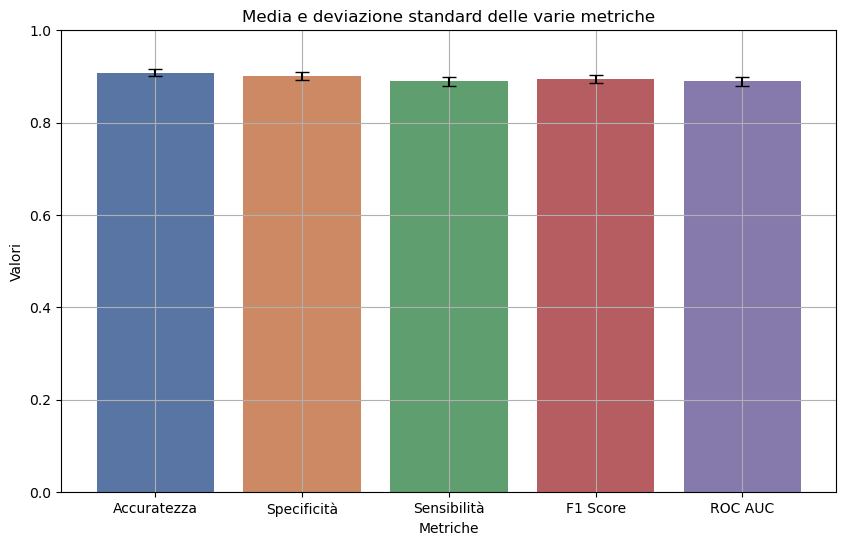

,Metrica,Media,Deviazione standard
0,Accuratezza,0.907766,0.007324
1,Specificità,0.900818,0.009193
2,Sensibilità,0.889036,0.009281
3,F1 Score,0.894426,0.008848
4,ROC AUC,0.889036,0.009281


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {
    'Accuratezza': accuracies,
    'Specificità': precisions,
    'Sensibilità': recalls,
    'F1 Score': f1_scores,
    'ROC AUC': roc_aucs
}
metrics_summary = {
    'Metrica': [],
    'Media': [],
    'Deviazione standard': []
}

for metric_name, values in metrics.items():
    metrics_summary['Metrica'].append(metric_name)
    metrics_summary['Media'].append(sum(values) / len(values))
    metrics_summary['Deviazione standard'].append(pd.Series(values).std())

# Converto in un dataframe
metrics_df = pd.DataFrame(metrics_summary)

# Traccia il grafico con seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Metrica', y='Media', data=metrics_df, capsize=0.2, palette='deep', errorbar=None)

# Aggiungi gli error bars manualmente
for index, row in metrics_df.iterrows():
    plt.errorbar(x=index, y=row['Media'], yerr=row['Deviazione standard'], fmt='none', c='black', capsize=5)

plt.xlabel('Metriche')
plt.ylabel('Valori')
plt.title('Media e deviazione standard delle varie metriche')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

metrics_df